## Vanilla Softmax

Built with reference to http://cs231n.github.io/assignments2017/assignment1/ 

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

In [2]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [4]:
from IPython.core.debugger import set_trace

In [5]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    PATH = 'data/cifar10'
    cifar10_dir = f'{PATH}'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape) 
print('Validation labels shape: ', y_val.shape) 
print('Test data shape: ', X_test.shape) 
print('Test labels shape: ', y_test.shape) 
print('dev data shape: ', X_dev.shape) 
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


### Softmax Classifier

![softmax](image/softmax.png)

In [30]:
import numpy as np
from random import shuffle

def softmax_loss_naive(W, X, y, reg):
    """
    Softmax loss function, naive implementation (with loops)

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using explicit loops.     #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    
    num_train = X.shape[0]
    num_class = W.shape[1]

    for i in range(num_train):
        f = X[i].dot(W)
        f -= np.max(f)
        
        p = lambda k: np.exp(f[k]) / np.sum(np.exp(f))
        loss += -np.log(p(y[i]))
        
        for k in range(num_class):
            p_k = p(k)
            dW[:, k] += (p_k - (k == y[i])) * X[i]
        
    loss /= num_train
    loss += 0.5 * reg * np.sum(W * W)
    
    dW /= num_train
    dW += reg * W
  
    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################  

    return loss, dW


def softmax_loss_vectorized(W, X, y, reg):
    """
    Softmax loss function, vectorized version.

    Inputs and outputs are the same as softmax_loss_naive.
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)
    
    #############################################################################
    # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    
    num_train = X.shape[0]
    
    # evaluate class scores
    scores = X.dot(W)
    
    # compute class probabilities
    scores -= np.max(scores, axis=1, keepdims=True)
    p = np.exp(scores)/np.sum(np.exp(scores), axis=1, keepdims=True)
    
    # compute loss
    loss = np.sum(-np.log(p[np.arange(num_train), y]))
    loss /= num_train
    loss += 0.5 * reg * np.sum(W * W)
    
    # Compute gradient on scores
    dscores = p.copy()
    dscores[np.arange(num_train), y] -= 1
    dscores /= num_train
    
    # Backprop to W2
    dW = X.T.dot(dscores)
    
    # add regularization gradient contribution
    dW += reg * W
    
    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################
    
    return loss, dW

In [7]:
# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1))) 

loss: 2.375372
sanity check: 2.302585


In [9]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -4.899664 analytic: -4.899664, relative error: 7.102829e-09
numerical: 2.983544 analytic: 2.983544, relative error: 5.485216e-09
numerical: -5.248942 analytic: -5.248942, relative error: 7.904575e-10
numerical: -1.767474 analytic: -1.767474, relative error: 1.374770e-08
numerical: -2.523050 analytic: -2.523050, relative error: 1.222475e-08
numerical: -1.385041 analytic: -1.385041, relative error: 1.338868e-08
numerical: -1.117644 analytic: -1.117644, relative error: 1.725831e-08
numerical: 1.666258 analytic: 1.666258, relative error: 8.790650e-09
numerical: 0.798105 analytic: 0.798105, relative error: 5.589171e-09
numerical: -2.159699 analytic: -2.159699, relative error: 4.164004e-09
numerical: -0.722003 analytic: -0.722003, relative error: 6.582134e-09
numerical: 0.105199 analytic: 0.105199, relative error: 6.043025e-08
numerical: 1.654562 analytic: 1.654562, relative error: 2.616091e-08
numerical: -0.485133 analytic: -0.485133, relative error: 3.489495e-08
numerical: -1.52

In [31]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference) 

naive loss: 2.375372e+00 computed in 0.159697s
vectorized loss: 2.375372e+00 computed in 0.007120s
Loss difference: 0.000000
Gradient difference: 0.000000


### Softmax Classifier

In [19]:
class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
          # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            sample_indices = np.random.choice(np.arange(num_train), batch_size)
            
            X_batch = X[sample_indices]
            y_batch = y[sample_indices]

          # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)
            
            self.W += -learning_rate * grad

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: D x N array of training data. Each column is a D-dimensional point.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[1])

        y_pred = np.argmax(X.dot(self.W), axis=1)

        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative. 
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass


class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)


class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)

In [20]:
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 781.014400
iteration 100 / 1500: loss 286.912764
iteration 200 / 1500: loss 106.263826
iteration 300 / 1500: loss 40.207989
iteration 400 / 1500: loss 16.040343
iteration 500 / 1500: loss 7.233705
iteration 600 / 1500: loss 3.998699
iteration 700 / 1500: loss 2.786313
iteration 800 / 1500: loss 2.396928
iteration 900 / 1500: loss 2.186534
iteration 1000 / 1500: loss 2.106685
iteration 1100 / 1500: loss 2.089099
iteration 1200 / 1500: loss 2.100860
iteration 1300 / 1500: loss 2.130106
iteration 1400 / 1500: loss 2.026210
That took 8.787317s


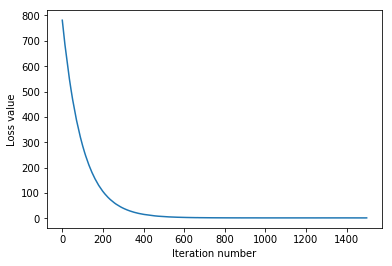

In [22]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [32]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e8]

iters = 100
for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=iters)
        
        y_train_pred = softmax.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(lr, rs)] = (acc_train, acc_val)
        
        if best_val < acc_val:
            best_val = acc_val
            best_softmax = softmax

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

/Users/JackyCSL/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in log
/Users/JackyCSL/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: overflow encountered in double_scalars
/Users/JackyCSL/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/Users/JackyCSL/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: overflow encountered in multiply


lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.145000 val accuracy: 0.165000
lr 1.000000e-07 reg 1.000000e+08 train accuracy: 0.078918 val accuracy: 0.084000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.300653 val accuracy: 0.314000
lr 5.000000e-07 reg 1.000000e+08 train accuracy: 0.085143 val accuracy: 0.079000
best validation accuracy achieved during cross-validation: 0.314000


In [26]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.286000


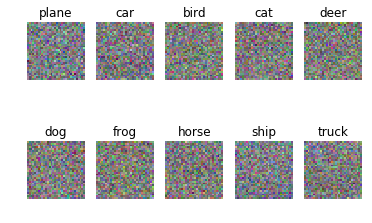

In [27]:

# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])